## 3.5 ガンマ補正

### この節について

この節では、ガンマ補正を行い画像の明るさとトーンを修正します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_toc.ipynb)から参照するか、以下のリンクを使ってアクセスしてください。

https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_3_5.ipynb

### 準備

まずこれまで行ったライブラリーのインストールと、モジュールのインポート、画像のダウンロード、及びRAW画像の読み込みを行います。
内容については各節を参照ください。

In [3]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt

# 前節までに作成したモジュールのダウンロード
!if [ ! -f raw_process.py ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi

from raw_process import simple_demosaic, white_balance, black_level_correction

# 日本語フォントの設定
!rm /root/.cache/matplotlib/fontList.json
!apt-get -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'
# もし日本語が文字化けしている場合Runtime->Restart Runtimeで再実行

# 画像をダウンロードします。
!if [ ! -f sample.ARW ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/sample.ARW; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "sample.ARW"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
rm: cannot remove '/root/.cache/matplotlib/fontList.json': Permission denied
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


### ガンマ補正とは

ガンマ補正というのは、もともとテレビがブラウン管だった頃にテレビの出力特性と信号の強度を調整するために使われていたものです。 

今でも残っているのは、ガンマ補正による特性が結果的に人間の目の非線形的な感度と相性が良かったからのようです。 そんなわけで現在でもディスプレイの輝度は信号に対してブラウン管と似たような信号特性を持って作られており、画像にはガンマ補正をかけておかないと出力は暗い画像になってしまいます。

ガンマ特性自体は次の式で表されます

$$ y = x^{2.2} $$

グラフで書くと次のようになります。

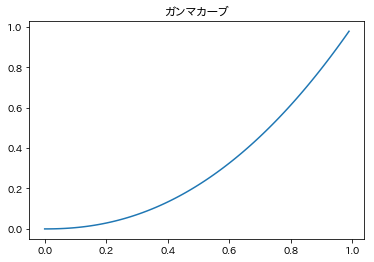

In [4]:
xs = np.arange(0.0, 1.0, 0.01)
ys = np.power(xs, 2.2)
plt.plot(xs, ys)
plt.title(u"ガンマカーブ")
plt.show()

モニターなどの出力の強さはは入力に対してこのような特性になるので、入力の方をこれに合わせて調整しておく必用があります。これがガンマ補正です。

ガンマ補正はこれを打ち消す必要があるので、このような式になります。

$$ y = x^{\frac{1}{2.2}} $$

グラフはこうなります。

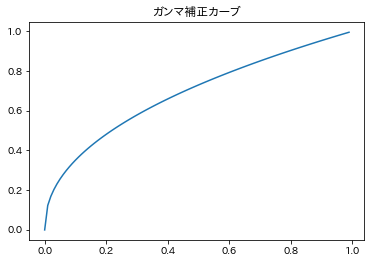

In [3]:
xs = np.arange(0.0, 1.0, 0.01)
ys = np.power(xs, 1/2.2)
plt.plot(xs, ys)
plt.title(u"ガンマ補正カーブ")
plt.show()

### ガンマ補正処理

それではガンマ補正をかけてみましょう。

ガンマをかけるのはデモザイクまで行ったRGB画像が対象ですので、まずブラックレベル補正、ホワイトバランス補正、簡易でモザイク処理をかけます。

In [4]:
# raw_processからインポートしたblack_level_correction関数を使用してブラックレベル補正。
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
# raw_processからインポートしたwhite_balance()関数を使って、ホワイトバランス調整。
wb_img = white_balance(blc_raw, raw.camera_whitebalance, raw.raw_colors)
# raw_processからインポートしたsimple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

画像が正常に処理できているか確認しておきましょう。

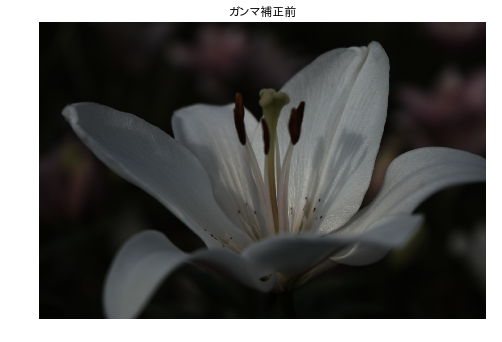

In [5]:
# 表示
plt.figure(figsize=(8, 8))
# imshowでは画像は0から1.0の値をとる必用があるので、ノーマライズする。
img = dms_img.copy()
img[img<0] = 0
img /= img.max()
img[img>1] = 1
plt.imshow(img)
plt.axis('off')
plt.title(u"ガンマ補正前")
plt.show()

デモザイクまでの処理は正常に行われたようなので実際にガンマ補正をかけてみましょう。

In [6]:
# デモザイク後の画像をfloatタイプとしてコピー。
gamma_img = dms_img.astype(float)
# ガンマ関数は0-1の範囲で定義されているので、その範囲に正規化する。
gamma_img[gamma_img < 0] = 0
gamma_img /= gamma_img.max()
# numpyのpower関数を使って、ガンマ関数を適用。
gamma_img = np.power(gamma_img, 1/2.2)

処理の結果を見てみましょう。

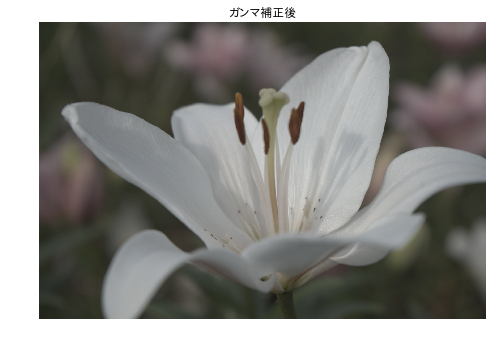

In [7]:
# 表示
plt.figure(figsize=(8, 8))
plt.imshow(gamma_img)
plt.axis('off')
plt.title(u"ガンマ補正後")
plt.show()

ガンマ補正により明るさが適正になりました。

### 処理のモジュール化

今回のガンマ補正もモジュールの一部としておきましょう。

In [10]:
def gamma_correction(input_img, gamma):
    """
    ガンマ補正処理を行う。

    Parameters
    ----------
    input_img: numpy array [h, w, 3]
        入力RGB画像データ。
        0-1の範囲で正規化されていること。
    gamma: float
        ガンマ補正値。通常は2.2。

    Returns
    -------
    gamma_img: numpy array [h, 2, 3]
        出力RGB画像。
    """
    # デモザイク後の画像をfloatタイプとしてコピー。
    gamma_img = input_img.copy()
    gamma_img[gamma_img < 0] = 0
    gamma_img[gamma_img > 1] = 1.0
    # numpyのpower関数を使って、ガンマ関数を適用。
    gamma_img = np.power(gamma_img, 1/gamma)
    return gamma_img

この`gamma_correction()`関数は`raw_process.py`モジュールの一部として[githubにアップロード](https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py)されています。
使用する場合は、

`!wget https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py`

としてダウンロードした後、

`from raw_process import gamma_correction`

としてインポートしてください。

### まとめ

この節ではガンマ補正を行いました。これで基本的な処理はすべておわりです。
次の章ではその他の[重要な処理](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_4.ipynb)を扱います。